# Memorization vs Generalization

Neuronale Netze gehören mittlerweile zum Standard-Repertoire des Maschienllen Lernens. Wir erwarten von ihnen, dass sie "einfach lernen". Doch was genau ist mit diesem Begiff eigentlich gemeint? 

## Lernen

Der Begriff _lernen_ lässt in diesem Zusammenhang zwei Interpretationen zu.
- "Learning by memorization": Das Modell lernt die Samples und kann die gelernten Daten später korrekt zuordnen. Ungesehene Daten werden nicht korrekt klassifiziert. 
- "Generalization": Das Modell extrahiert aus den Samples Regeln, die für eine Zuordnung von Bedeutung sind. Durch Anwendung dieser allgemeinen Regeln auf ungesehene Daten können auch diese korrekt klassifiziert werden.

(Shai Shalev-Shwartz und Shai Ben-David, Understanding machine learning: from theory to algorithms (New York, NY, USA: Cambridge University Press, 2014).)

In der Regel erwartet man bei dem Begriff _lernen_ zweiteres. Das Modell soll mit den Trainingsdaten lernen, zusammenhänge und Regeln zu erkennen und auf neue, ungesehene Daten anwenden können. 

In diesem Notebook werden wir uns jedoch mit dem ersteren beschäftigen – der Memorization. Auch hierbei leisten DNN durchaus erstaunliches und ein Verständnis dieser Thematik hilft dabei Netze zu entwickeln die besser generalisieren können. 

## Testumgebung

Wir verwenden in diesem Notebook die Folgende kleine Testumgebung um vergleichbare CNNs mit veschiedenen Parametern und Trainingsdaten zu erstellen und auszwerten. Die Erstellung der netzte erfolgt mit Keras, da es eine einfache und nachvollziehbare API bietet mit deren Hilfe sehr schnell und effizient verschiedene Netze erstellt werden können. Als Backend zur eigentlichen Ausführung fungiert Tensorflow, daher ist auch eine schnelle Ausführung auf einer GPU möglich. 
Mithilfe der GPU werden die Netze erheblich schneller trainiert, daher wird die Verwendung empfohlen.
Zum Einsatz kamen bei der Entwicklung Python3.6, tensorflow 1.15.3 und keras 2.3.1.

### Konfigurationsparameter

- FORCE_BUILD_MODELS: Wird der Parameter auf `TRUE` gesetzt, werden alle Modelle neu trainiert, im anderen Fall werden zuerst die gespeicherten Modelle geladen, eine Neuberechnung findet nur statt, wenn kein gespeichertes Modell vorhanden ist.

In [1]:
import pickle
from matplotlib import pyplot
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import SGD, RMSprop, Adam
from keras.regularizers import l2
import random, os, json

FORCE_BUILD_MODELS = False
BATCH_SIZE = 64

Using TensorFlow backend.


Wir verwenden das CIFAR10 Dataset, welches aus 60000 niedrig aufgelösten Bildern besteht, welche 10 verschiedenen Klassen zugeordnet sind. 

Die Erste Zeile im folgenden Code-Beispiel lädt die CIFAR10 Daten herunter. 50000 Bilder (trainX) und die entsprechenden Labels (trainY) sind die Trainingsdaten und 10000 Bilder werden als Validierungsset genutzt. D.h. wir haben zum überprüfen des Lernerfolges 10000 Bilder, die das Modell im Training nie gesehen hat.

Die im Folgenden verwendete Terminologie:
* **Trainingsdaten** Als Traningsdaten werden die 50000 Bilder des CIFAR10 Datensatzes bezeichnet, mit denen das Modell trainiert wird.
* **Valdidierungsdaten** Als Validierungsdaten werden die 10000 Bilder des CIFAR10 Datensatzes bezeichnet, die nicht zum Training verwendet werden, sondern nur zum validieren der Generalisierung.
* **Labels** Als Label wird die Klasse bezeichnet, der das entsprechende Bild aus den Trainingsdaten zugeordnet wird. Im Quellcode wird dieser Teil auch als "Y" bezeichnet, angelehnt an die mathemtische Bezeichnung für das Ergebnis einer beliebigen Funktion.
* **Eingabedaten** Als Eingabedaten, wird der Teil des Datensatzes bezeichnet, der die Bilder beinhaltet ohne die entsprechenden Labels. Es ist der Teil des Datensatzes der "in das DNN hineingegeben" wird. Im Quellcode wird dieser Teil auch als "X" bezeichnet. 

Zur Veranschaulichung der Daten und um ein Gefühl dafür zu kriegen, lassen wir uns einige zufällig ausgewählte Bilder mit den entsprechenden Labels anzeigen. 

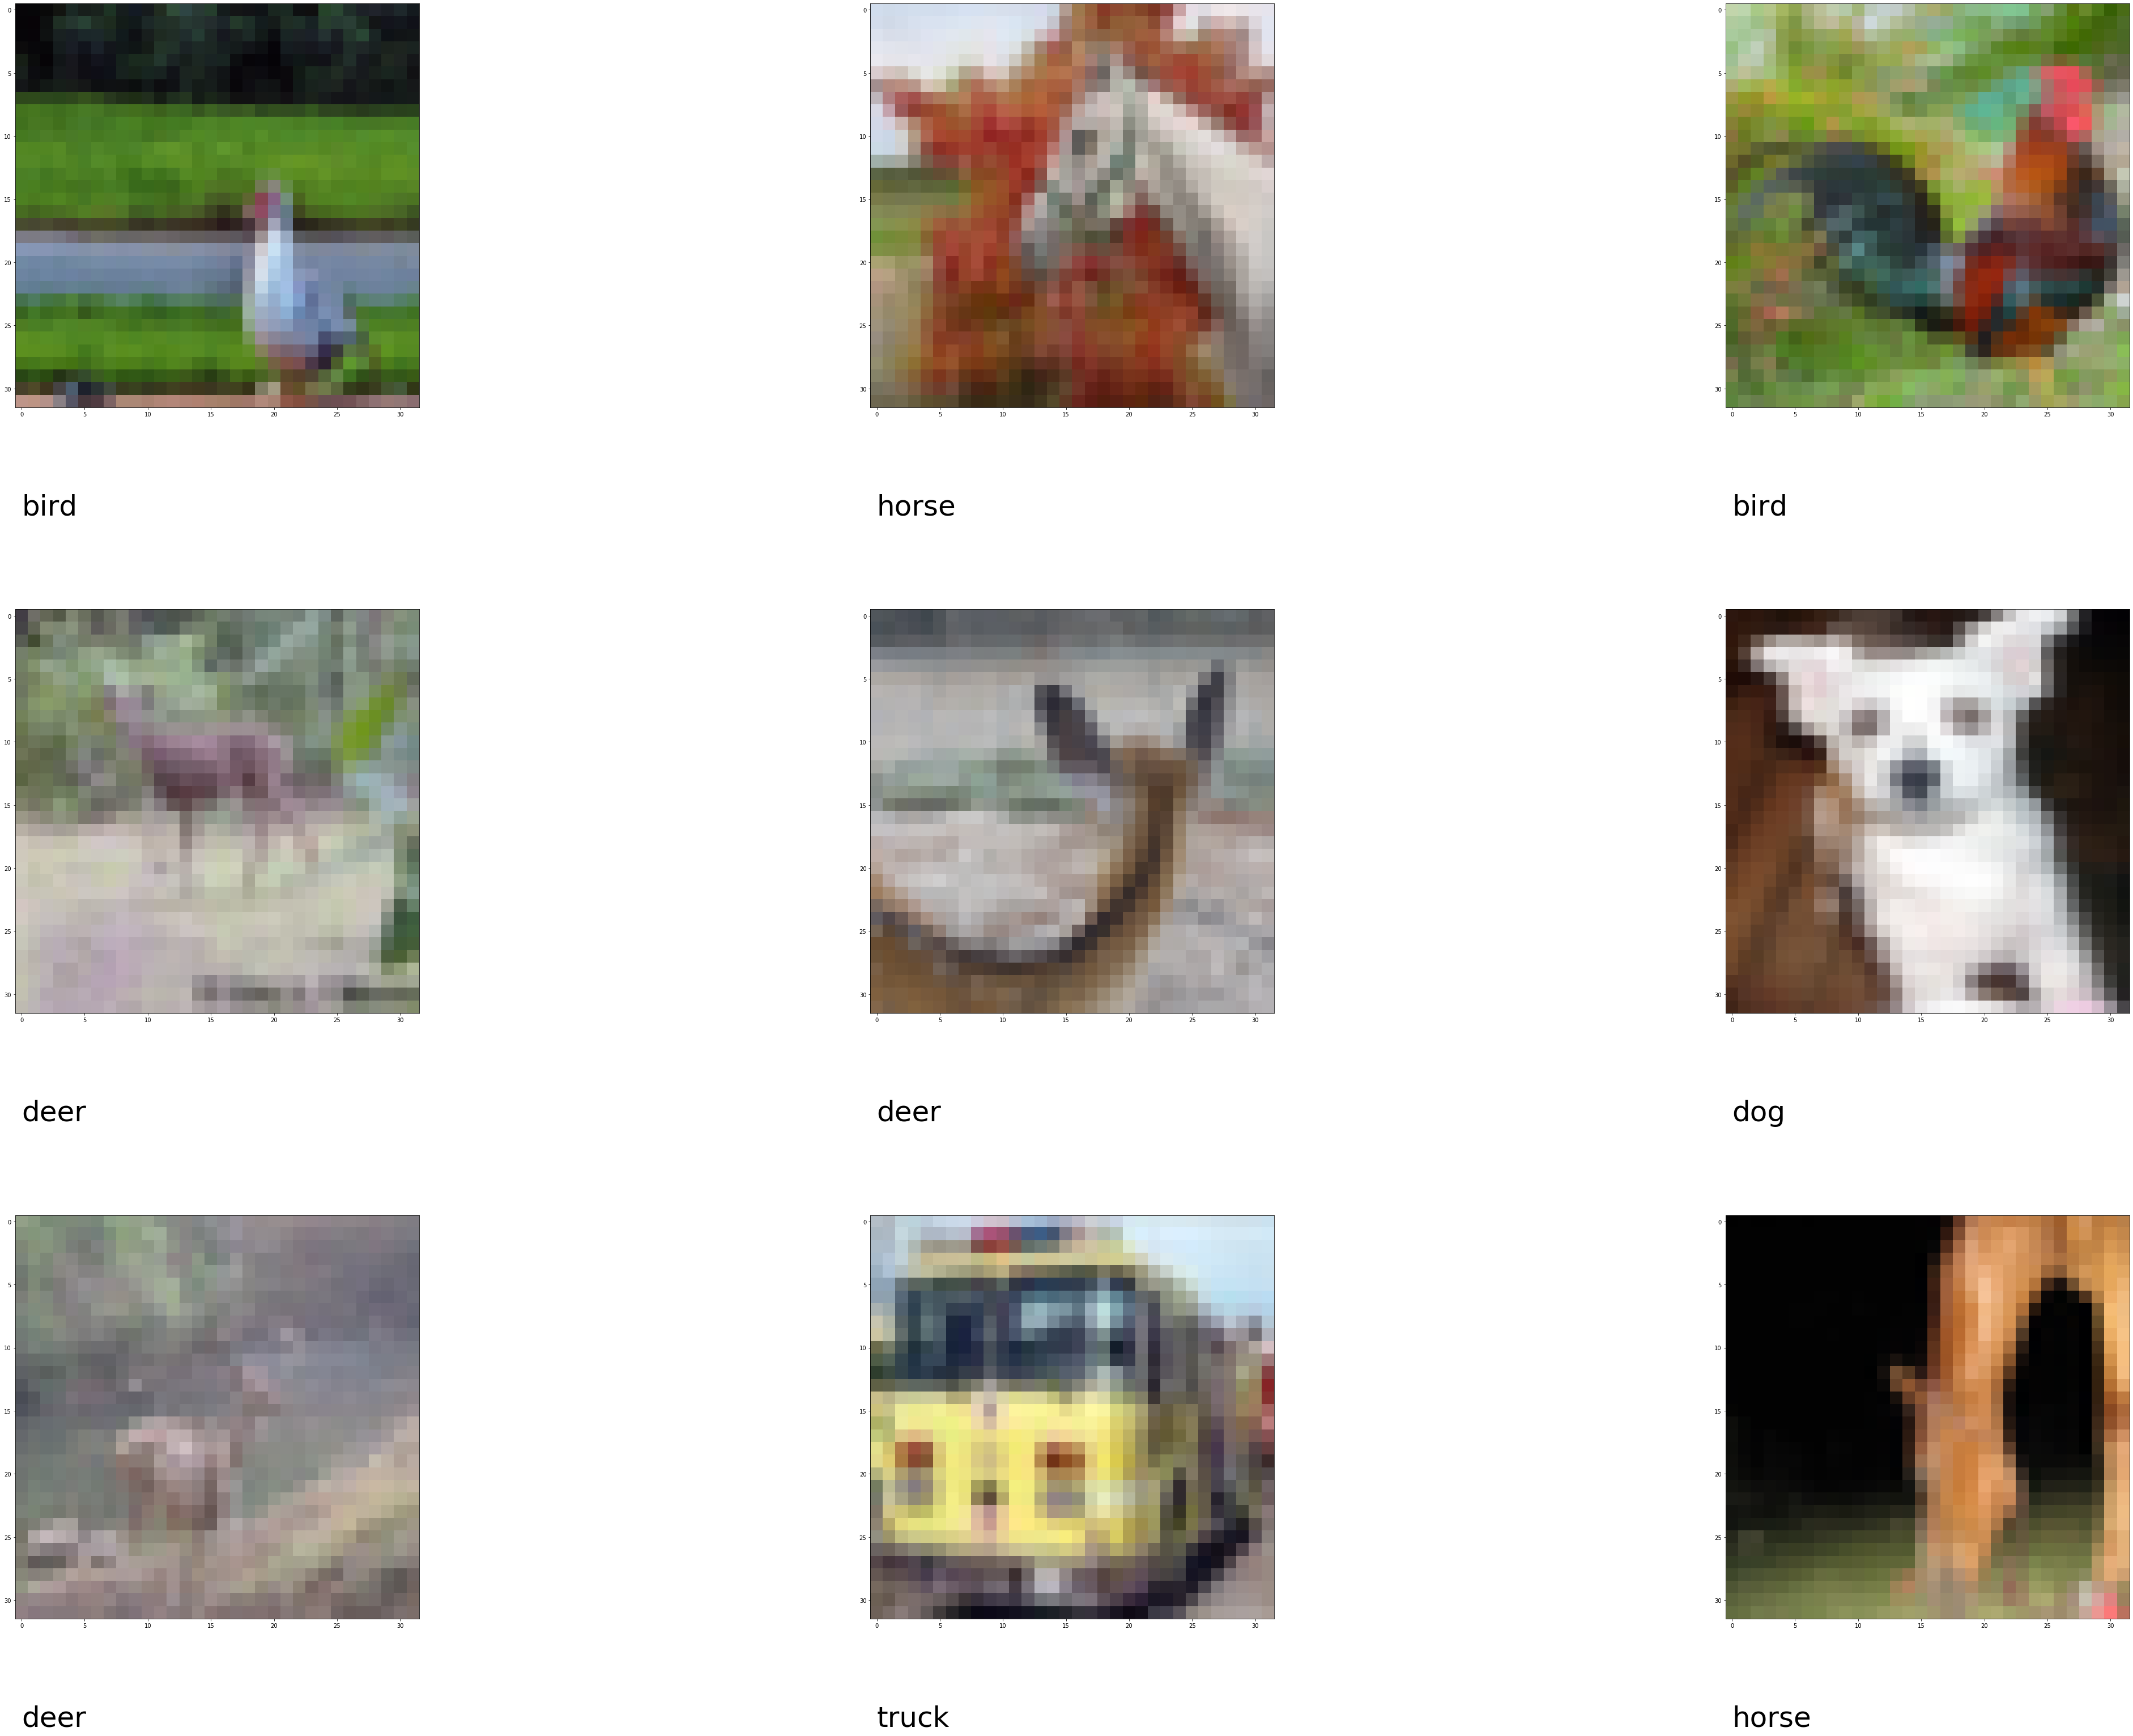

In [2]:
(trainX, trainY), (valX, valY) = cifar10.load_data()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(9):
    nr = random.randint(1, len(trainX))
    pyplot.subplot(330 + 1 + i, ymargin=20)
    pyplot.imshow(trainX[nr])
    pyplot.text(0, 40, class_names[trainY[nr][0]], fontsize=50)

#pyplot.tight_layout()
pyplot.subplots_adjust(left=0.1, right=10.0, top=10.0, bottom=0.1, hspace=0.5)
pyplot.show()



Wir sehen, Bilder sind sehr niedrig aufgelöst und eine Zuordnung fällt auch für das menschliche Gehirn nicht in allen Fällen leicht. Zudem gibt es auch einige falsch zugeordnete Bilder im Dataset.

Für die späteren Experimente kopieren wir die Liste der Labels und mischen die Labels durch. Damit erlischt der logische Zusammenhang zwischen Bildern und Labels.

In [3]:
trainY_shuffle = list(trainY)
random.shuffle(trainY_shuffle)

Als nächstes werden die Daten des CIFAR10-Datensatzes vorbereitet. 
Die Labels liegen als numerische Bezeichnung der Klasse zwischen 0 und 9 vor. Zur Multiclass-Classification benötigen wir die Werte jedoch als Binary-Class-Matrix. Der Wert 1 wird zu 0100000000 oder der Wert 9 wird zu 0000000001.

Als nächstes werden die Eingabedaten in Gleitkommawerte gewandelt und auf Werte zwischen 0 und 1 normalisiert.

In [4]:
trainY = to_categorical(trainY)
valY = to_categorical(valY)
trainY_shuffle = to_categorical(trainY_shuffle)

trainX = trainX.astype('float32')
valX = valX.astype('float32')

trainX = trainX / 255.0
valX = valX / 255.0


Im Folgdenen werden einige Funktionen definiert, die im Laufe des Notebooks für einige Experimente genutzt werden.

In [5]:
def create_model(conv1_count, conv2_count=0, conv3_count=0, add_dropout=False, l2_regularization=None, dense_count=10):
    """
    Die Funktion erstellt mithilfe der Keras Sequential-API ein Neuronales Modell und gibt es zurück.
    Das Modell besteht aus 2, 4 oder 6 Convolutional-Schichten mit variabler Anzahl an Kerneln. 
    Zwischen den Schichten liegen MaxPooling-Schichten und evtl. Dropouts.
    Darauf folgen eine FC-Schicht mit variabler Anzahl an Neuronen und eine Softmax-Schicht als Ausgabe für die 10 Klassen.
    
    Parameter:
    conv1_count: Anzahl der Kernel der 1. Conv-Schicht. Required.
    conv2_count: Anzahl der Kernel der 2. Conv-Schicht. Bei 0 wird die Schicht nicht genutzt.
    conv3_count: Anzahl der Kernel der 3. Conv-Schicht. Bei 0 wird die Schicht nicht genutzt.
    add_droput: Wert zwischen 0 und 1. Der Wert wird als Parameter an die Droput-Schicht weitergegeben. Bei 0 werden keine Droput-Schichten erzeugt.
    l2_regularization: Bei True werden die Schichten mit einer L2-Kernel-Regularisirungsschicht erstellt.
    dense_count: Anzahl der Neuronen in der FC-Schicht nach den Conv-Schichten.
    """
    kernel_regularizer = l2(0.0001) if l2_regularization else None
        
    model = Sequential()
    model.add(Conv2D(conv1_count, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=kernel_regularizer, padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(conv1_count, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=kernel_regularizer, padding='same'))
    model.add(MaxPooling2D((2, 2)))
    if add_dropout:
        model.add(Dropout(add_dropout))
    if conv2_count != 0:
        model.add(Conv2D(conv2_count, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=kernel_regularizer, padding='same'))
        model.add(Conv2D(conv2_count, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=kernel_regularizer, padding='same'))
        model.add(MaxPooling2D((2, 2)))
        if add_dropout:
            model.add(Dropout(add_dropout))
    if conv3_count != 0:
        model.add(Conv2D(conv3_count, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=kernel_regularizer, padding='same'))
        model.add(Conv2D(conv3_count, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=kernel_regularizer, padding='same'))
        model.add(MaxPooling2D((2, 2)))
        if add_dropout:
            model.add(Dropout(add_dropout))

    model.add(Flatten())
    model.add(Dense(dense_count, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=kernel_regularizer))
    if add_dropout:
        model.add(Dropout(add_dropout))
    model.add(Dense(10, activation='softmax'))
    #opt = SGD(lr=0.001, momentum=0.9)
    #opt = RMSprop(learning_rate=0.0001, decay=1e-6)
    opt = Adam(learning_rate=0.0002)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    print('Using kernel_regularizer: {}'.format(kernel_regularizer))
    model.summary()
    return model


def plot_summary(history):
    """
    Diese Funktion zeichnet 2 Diagramme. Einmal das Loss und die Accuracy eines Trainingslaufs.
    
    Parameter:
    history: Ein Keras History Objekt.
    """
    # Plot the loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history['loss'], color='blue', label='train')
    pyplot.plot(history['val_loss'], color='red', label='test')
    pyplot.legend(loc='lower right')
    # Plot the accuracy
    pyplot.subplot(212)
    pyplot.title('Accuracy')
    pyplot.plot(history['accuracy'], color='blue', label='train')
    pyplot.plot(history['val_accuracy'], color='red', label='test')
    pyplot.legend(loc='lower right')
    

def print_summary(model, history):
    """
    Diese Funktion schreibt einige Informationen zu einem trainierten Modell in die Ausgabe.
    
    Parameter:
    model: Ein Keras.Model Objekt.
    history: Ein Keras History Objekt.
    """
    print("Parameter: {:,}".format(model.count_params()))
    print("Final Accuracy: {}; Final Validation Accuracy: {}".format(history['accuracy'][-1], history['val_accuracy'][-1]))

    
def create_or_load_model(name, model_params, train_func):
    """
    Diese Funktion dient dazu, den kompletten Zyklus vom erstellen des Modells bis zum Trainieren und Speichern zu kapseln. 
    Es wird überprüft, ob ein Modell des übergebenen Namens bereits gespeichert ist. Ist dies der Fall, wird es geladen und die 
    zugehörige trainings History ebenfalls.
    Existiert kein gespeichertes Modell, wird mithilfe der Funktion create_model und übergebenen Parametern ein Modell erstellt.
    Anschließend wird das Modell trainiert und nach erfolgreichem Training gespeichert. 
    
    Parameter:
    name: Der eindeutige Name des Modells als String.
    model_params: Ein Dict mit den Parametern zur Erstellung des Modells. Die Parameter sind in der Funktion create_model dokumentiert.
    train_func: Eine Funktion, die das Training des Modells durchführt. Sie wird mit dem Keras.Model als Parameter aufgerufen.
                Hier sollte ein lambda-Ausdruck mit einem Parameter genutzt werden. Da dieser Parameter beim Aufruf das Keras.Model ist, 
                kann darauf direkt ein Aufruf von Beispielsweise fit() erfolgen.
    """
    model_path = 'models/{}.model'.format(name)
    history_path = 'models/{}_history.pickle'.format(name)
    if os.path.isfile(model_path) and not FORCE_BUILD_MODELS:
        ''' Das Modell exisitiert und der Parameter FORCE_BUILD_MODELS ist nicht gesetzt. => Modell laden. '''
        model = load_model(model_path)
        with open(history_path, mode='rb') as file:
            history = pickle.load(file)
    else:
        ''' Das Modell muss neu erstellt und trainiert werden. '''
        model = create_model(**model_params)
        history = train_func(model)
        model.save(model_path)
        with open(history_path, 'wb') as file:
            pickle.dump(history.history, file)
            history = history.history
    return (model, history)



# Experimente

## Referenzmodell

Zuerst wird ein Modell mit den korrekten Trainingsdaten trainiert. 

In [24]:
normal_params = dict(conv1_count=32, conv2_count=64, conv3_count=128, add_dropout=False, dense_count=512)
model_normal, history_normal = create_or_load_model('normal', normal_params, lambda model: model.fit(trainX, trainY, epochs=100, batch_size=BATCH_SIZE, validation_data=(valX, valY)))

Parameter: 1,341,226
Final Accuracy: 0.995199978351593; Final Validation Accuracy: 0.7501000165939331


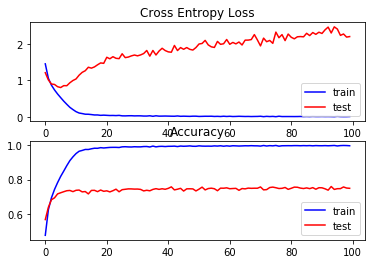

In [7]:
print_summary(model_normal, history_normal)
plot_summary(history_normal)

Loss

## Randomisierte Labels

Dieses Modell ist das gleiche wie oben, nur dass dieses mal die randomisierten Labels genutzt werden. D.h. das Modell bekommt die gleichen Eingabedaten, aber die Labels dazu sind komplett durcheinander gewürfelt.

In [26]:
model_random, history_random = create_or_load_model('random', normal_params, lambda model: model.fit(trainX, trainY_shuffle, epochs=100, batch_size=BATCH_SIZE,  validation_data=(valX, valY)))


Parameter: 1,341,226
Final Accuracy: 0.9882199764251709; Final Validation Accuracy: 0.10589999705553055


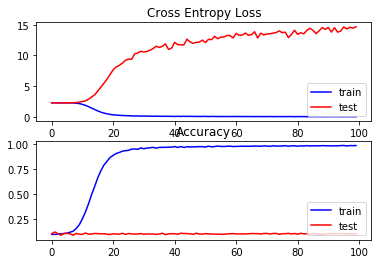

In [27]:
print_summary(model_random, history_random)
plot_summary(history_random)

## Vergleich zwischen echten und randomisierten Labels

Im folgenden Diagramm wird die Accuracy der Validationsets über 100 Episoden dargestellt.

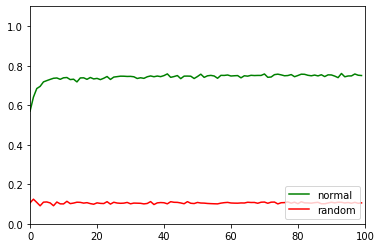

In [28]:
pyplot.plot(history_normal['val_accuracy'], color='green', label='normal')
pyplot.plot(history_random['val_accuracy'], color='red', label='random')
pyplot.axis([0, 100, 0, 1.1])
pyplot.legend(loc='lower right')
pyplot.show()

Das Referenz-Modell erreicht eine zufriedenstellende Leistung von knapp 75%.

Wenig überraschend ist die Performance des randomisierten Modells bei knapp 10%, was bei 10 Klassen genau der zu erwartenten Wahrscheinlichkeit einer rein zufälligen Klassenzuordnung entspricht. Das Modell hat aus den Trainingsdaten also keine Regeln zur Generalisierung ableiten können.

Das folgende Diagramm vergleicht die Accuracy der Trainingsdaten der biden Varianten miteinander.

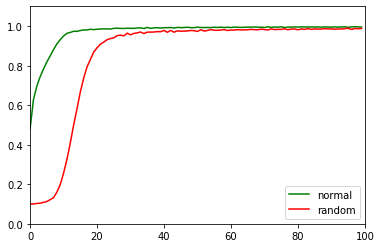

In [11]:
pyplot.plot(history_normal['accuracy'], color='green', label='normal')
pyplot.plot(history_random['accuracy'], color='red', label='random')
pyplot.axis([0, 100, 0, 1.1])
pyplot.legend(loc='lower right')
pyplot.show()

Hier ergibt sich ein interessanteres Bild. Beide Modelle sind in der Lage, die Klassifikation der Daten nahezu vollständig zu erinnern. Auch das Modell, welches die Daten mit randomisierten Klassen zum Training bekommen hat, ist nach einer langsamen Anfangsphase relativ schnell in der Lage die Daten zu erinnern. 
Der Großteil des "auswendig lernens" passiert innerhalb von nur 25 Episoden, eine ähnlich lange Zeit benötigt auch das Referenz-Modell, nur dass hier die Erinnerung schon nach 25 Episoden fast abgeschlossen ist. 

Wir sehen hier also genau das Verhalten, dass wir zum Generalisieren nicht haben wollen. Das Modell lernt Zusammenhänge, die semantisch nicht existieren. 


## Einfluss der Kapazität

### Kapazität 

Jedes mathmatische Modell bestetht aus einer bestimmten Anzahl an Parametern. Diese beschränken die Möglichkeit eines Modells, sich einer beliebigen Funktion anzunähern. (Kapazität und fähigkeit von Netzen Daten zu speichern, paper wiederfinden)

Die Kapazität eines Neuronalen Netzwerkes bestimmt sich durch die Anzahl und Größe der verstecken Schichten. Als Richtwert, lässt sich die Anzahl der Parameter nutzen. 
Eine exakte Angabe der Kapazität ist jedoch nur schwer möglich. (Goodfellow, Bengio, und Courville 2016)


In [29]:
small_params = dict(conv1_count=3, add_dropout=False, dense_count=128)
model_small, history_small = create_or_load_model('small', small_params, lambda model: model.fit(trainX, trainY, epochs=100, batch_size=BATCH_SIZE, validation_data=(valX, valY)))


Parameter: 99,890
Final Accuracy: 0.8963199853897095; Final Validation Accuracy: 0.5142999887466431


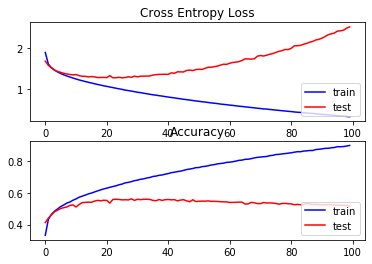

In [30]:
print_summary(model_small, history_small)
plot_summary(history_small)

Es ist schnell ersichtlich, dass sich das Modell deutlich schwerer damit tut. Die Accuracy des Validierungssets ist am Ende nur bei knapp 50% und sogar ein wenig mit dem Trend nach unten. 
Auch die Accuracy der Trainingsdaten steigt deutlich langsamer. erreicht am Ende aber doch ähnliche Bereiche wie bei dem viel größeren Modell. 
Auch mit seinen kanpp 0,1 Mio Parametern hat dieses Netz, nach genügend Trainingsepisoden genug Kapazität um die Daten korrekt zu erinnern.

Die Kapazität eines DNN ist damit schwer zu fassen und hängt neben der Anzahl der Parameter auch von der Anzahl der Trainingsschritte ab. 

## Overfitting

In direkter Verbindung zu der Fähigkeit von DNN "auswendig" zu lernen steht das sogenannte Overfitting. Overfitting – Überanpassung – entsteht immer dann, wenn ein Modell zu sehr auf spezielle Trainingsdaten traniert wird und damit die generalisierungsleistung abnimmt. (The TensorFlow Authors, „Explore Overfitting and Underfitting“, 2018, https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/overfit_and_underfit.ipynb#scrollTo=kRTxFhXAlnl1)

Nach herkömlicher Theorie entsteht eine Überanpassung, wenn ein Modell deutlich mehr Parameter hat als Trainingsdaten. Im Rahmen von DNN verhält sich dies etwas anders und die Gründe hierfür sind noch nicht ausreichend erforscht. (Devansh Arpit u. a., „A Closer Look at Memorization in Deep Networks“, arXiv:1706.05394 [cs, stat], 16. Juni 2017, http://arxiv.org/abs/1706.05394)

Wir betrachten im Folgenden einige Möglichkeiten Overfitting entgegenzuwirken und ihre Zusammenhnge mit dem "auswendig lernen".


## Regularization

Eine weitere Methode um zu verhindern, dass DNNs die Daten auswendig lernen sind explizite Regularisierungstechniken. 

Hier kommen insbesondere 2 Verfahren in Betracht:
- L1/L2 Regularization
- Dropout: Beim Dropout wird ein Teil der Neuronen einer Schicht bei jedem Schritt des Trainings deaktiviert. 

Zur Verdeutlichung der Funktionsweise von Regularisierung betrachten wir an dieser Stelle L2-Regularization und Dropout. Die Vorgehensweise ist leicht auf andere Regularisierungsverfahren übertragbar. (https://keras.io/api/layers/regularization_layers/) 



### L2-Regularisierung mit echten Labels

In [31]:
l2_params = dict(conv1_count=32, conv2_count=64, conv3_count=128, add_dropout=None, l2_regularization=True, dense_count=512)
model_l2_normal, history_l2_normal = create_or_load_model('l2_normal', l2_params, lambda model: model.fit(trainX, trainY, epochs=100, batch_size=BATCH_SIZE, validation_data=(valX, valY)))

Parameter: 1,341,226
Final Accuracy: 0.9863399863243103; Final Validation Accuracy: 0.7590000033378601


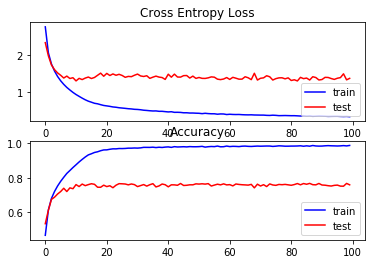

In [32]:
print_summary(model_l2_normal, history_l2_normal)
plot_summary(history_l2_normal)

### L2-Regularisierung mit randomisierten Labels

In [16]:
model_l2_random, history_l2_random = create_or_load_model('l2_random', l2_params, lambda model: model.fit(trainX, trainY_shuffle, epochs=100, batch_size=BATCH_SIZE, validation_data=(valX, valY)))

Parameter: 1,341,226
Final Accuracy: 0.9825400114059448; Final Validation Accuracy: 0.09709999710321426


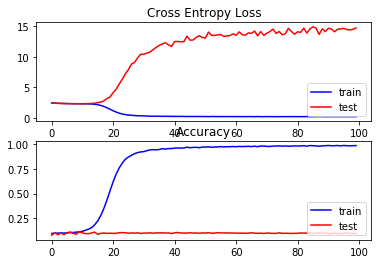

In [17]:
print_summary(model_l2_random, history_l2_random)
plot_summary(history_l2_random)

### Dropout mit echten Labels

In [18]:
reg_params = dict(conv1_count=32, conv2_count=64, conv3_count=128, add_dropout=0.25, dense_count=512)
model_dropout_normal, history_dropout_normal = create_or_load_model('dropout_normal', reg_params, lambda model: model.fit(trainX, trainY, epochs=100, batch_size=BATCH_SIZE, validation_data=(valX, valY)))

Parameter: 1,341,226
Final Accuracy: 0.9755399823188782; Final Validation Accuracy: 0.8296999931335449


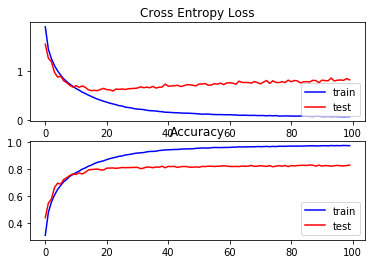

In [19]:
print_summary(model_dropout_normal, history_dropout_normal)
plot_summary(history_dropout_normal)

### Dropout mit randomisierten Labels

In [20]:
model_dropout_random, history_dropout_random = create_or_load_model('dropout_random', reg_params, lambda model: model.fit(trainX, trainY_shuffle, epochs=100, batch_size=BATCH_SIZE, validation_data=(valX, valY)))

Parameter: 1,341,226
Final Accuracy: 0.6175199747085571; Final Validation Accuracy: 0.10090000182390213


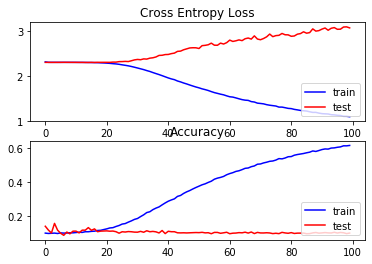

In [21]:
print_summary(model_dropout_random, history_dropout_random)
plot_summary(history_dropout_random)

### Vergleich der Regularisierungen

Wir vergleichen an dieser Stelle zwei unterschiedliche Werte, einmal die Validierungs Accuracy der echten Trainingsdaten und die trainings Accuracy der randomisierten Daten. Ersteres soll uns Informationen über die allgemeine Generalisierungsfähigkeit des Modells liefern und letzteres über die Fähigkeit die Daten "auswendig zu lernen".

#### Echte Labels

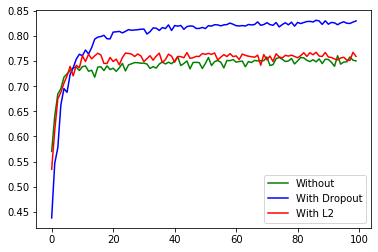

In [35]:
pyplot.plot(history_normal['val_accuracy'], color='green', label='Without')
pyplot.plot(history_dropout_normal['val_accuracy'], color='blue', label='With Dropout')
pyplot.plot(history_l2_normal['val_accuracy'], color='red', label='With L2')
pyplot.legend(loc='lower right')
pyplot.show()

Die Ergebnisse des Validierungssets sind mit Dropout signifikant besser als ohne. Eine leichte Steigerung der Accuracy erkennen wir in dem Modell mit L2-Regularisierung.

#### Randomisierte Labels

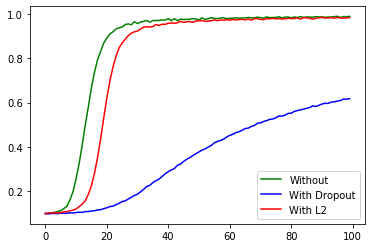

In [37]:
pyplot.plot(history_random['accuracy'], color='green', label='Without')
pyplot.plot(history_dropout_random['accuracy'], color='blue', label='With Dropout')
pyplot.plot(history_l2_random['accuracy'], color='red', label='With L2')
pyplot.legend(loc='lower right')
pyplot.show()

Es wird schnell deutlich, dass das Modell mit Dropout die randomisierten Daten deutlich langsamer lernt, als die anderen. Zusätzlich ist die Accuracy nach 100 Episoden nur bei knapp 75%. Es ist ein klarer Zusammenhang zwischen einer schlechteren Performance im "auswendig lernen" und einer besseren Performance im generalisieren ersichtlich. 


## Fazit

Wir haben uns in diesem Notebook mit dem Zusammenhang von "auswendig lernen" und overfitting beschäftigt und gezeigt, dass diese beiden eng miteinander zusammen hängen. Bekannte Methoden zur Verhinderung von overfitting haben auch zu einer Veränderung des memorization-Verhaltens Neuronaler Netze geführt. Möglicherweise ist dies daher eine brauchbare Methode, verschiedene Regularisierungstechniken auf ihre Effektivität bezüglich eines bestimmten Problems zu untersuchen. 
Beachten sollte man jedoch, dass auch durch die zufällige Verwürfelung der Labels durch Zufall neue semantische Zusammenhänge entstehen können, die auch hier eine Generalisierung des Netzes ermöglichen, die jedoch nicht gewollt ist. Zhang et al haben in ihrem Paper noch einige weitere Experimente gemacht, zum Beispiel mit vertauschten Pixeln oder komplett zufällig generierten Pixeln. Dies stellt möglicherweise eine bessere Methode dar, wirklich keine semantischen Zusammenhänge in den Daten zu haben. (Chiyuan Zhang u. a., „Understanding deep learning requires rethinking generalization“, arXiv:1611.03530 [cs], 10. November 2016, http://arxiv.org/abs/1611.03530)